Source: Sheldon Coup (MSc, UC)

# Importing needed libraries

In [2]:
!pip install scikeras

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import *
#from tf.keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from scikeras.wrappers import KerasClassifier

In [21]:
import tensorflow as tf

# Utility functions

In [6]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

# Main section

We will be using the MNIST dataset, which is built into Keras.
[MNIST](https://en.wikipedia.org/wiki/MNIST_database)

In [7]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


First of all we need to know what the size of the data we are dealing with is. \\
x_train, y_train, x_test and y_test are all numpy arrays, so we can just have a look at the shape attribute of each of them.
[More info on Numpy](https://www.numpy.org/)

In [8]:
print("Training data shape: ", x_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", x_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

image_size = (x_train.shape[1], x_train.shape[2])

Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)
Training response shape:,  (60000,)
Testing response shape:  (10000,)


This shows that we have 28 * 28 dimensional images with 60000 training images and 10000 testing images. \\
Next, in order to use a fully connected network to classify the images we need to convert these 28 * 28 images into vectors. \\
This can be done easily using the reshape function in numpy. [See this manual for more information of reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) \\
Additionally, as the inputs are images, we will rescale the vector values to be between 0 and 1 (rather than between 0 and 255). It will help our models to learn.

In [9]:
# Flatten the images
image_vector_size = image_size[0] * image_size[1] # 28 * 28
x_train = x_train.reshape(x_train.shape[0], image_vector_size) /255.
x_test = x_test.reshape(x_test.shape[0], image_vector_size) /255.
print(x_train.shape)

(60000, 784)


The final step in the data preparation is to convert the integer labels (target labels, what we want to predict) to one-hot encoded labels. \\
We convert labels "0", "1",...,"9" into vectors 1000000, 0100000,...,0000001. \\
Keras has a built in function that does this named to_categorical. \\
Be careful here, if you run this section of code more than once then you might one-hot-encode your one-hot-encoded labels!

In [10]:
print("First 5 training labels: ", y_train[:5]) # [5, 0, 4, 1, 9]

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [5 0 4 1 9]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(60000, 10)


Next we want to initialize our neural network model. \\
We start by defining the model from the Sequential() function and adding some Dense (fully-connected) layers. \\
Here we will be starting with a simple network with just a single hidden layer with 32 neurons. \\
Make sure you set the size of the output layer to be the number of classes that we are trying to predict! \\
We can have a look at out model using the model.summary() function.

In [11]:
#image_size = 784 # 28*28
#num_classes = 10 # ten unique digits
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 25450 (99.41 KB)
Trainable params: 25450 (99.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Before training we must compile out model and select three important things:

1.   Paramaters of  optimisitation procedure to use. For now we will be using simple SGD - gradient descent, this optimizer is the first one to ever be used in practice and the most simple to understand. By default in Keras, SGD is a gradient descent  with a fixed learning rate.
There are lots of other options for optimisation that we could look at though, for example using adaptive learning rate RMSprop, Adam, Adadelta, etc

2.   What loss function to use. For classification this loss function is almost always 'categorical_crossentropy', but if we were doing regression then we would be using a different loss function. Which one?

3. Finally, a metric. Generally, for classification, we are looking at the accuracy of the model. However we could also look at things like top k accuracy.


In [12]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

Finally, we are able to train our model to do some classification. Here we must select how long we wish to train for (epochs) and the mini-batch size.

In [13]:

history = model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.1298 - accuracy: 0.4149 - val_loss: 1.9259 - val_accuracy: 0.6305
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 1.7872 - accuracy: 0.6591 - val_loss: 1.6157 - val_accuracy: 0.7418
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 1.5145 - accuracy: 0.7289 - val_loss: 1.3563 - val_accuracy: 0.7935
Epoch 4/5
422/422 [==============================] - 2s 4ms/step - loss: 1.2933 - accuracy: 0.7684 - val_loss: 1.1507 - val_accuracy: 0.8217
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 1.1208 - accuracy: 0.7929 - val_loss: 0.9924 - val_accuracy: 0.8430


Test loss: 1.02
Test accuracy: 0.815


<Figure size 800x600 with 0 Axes>

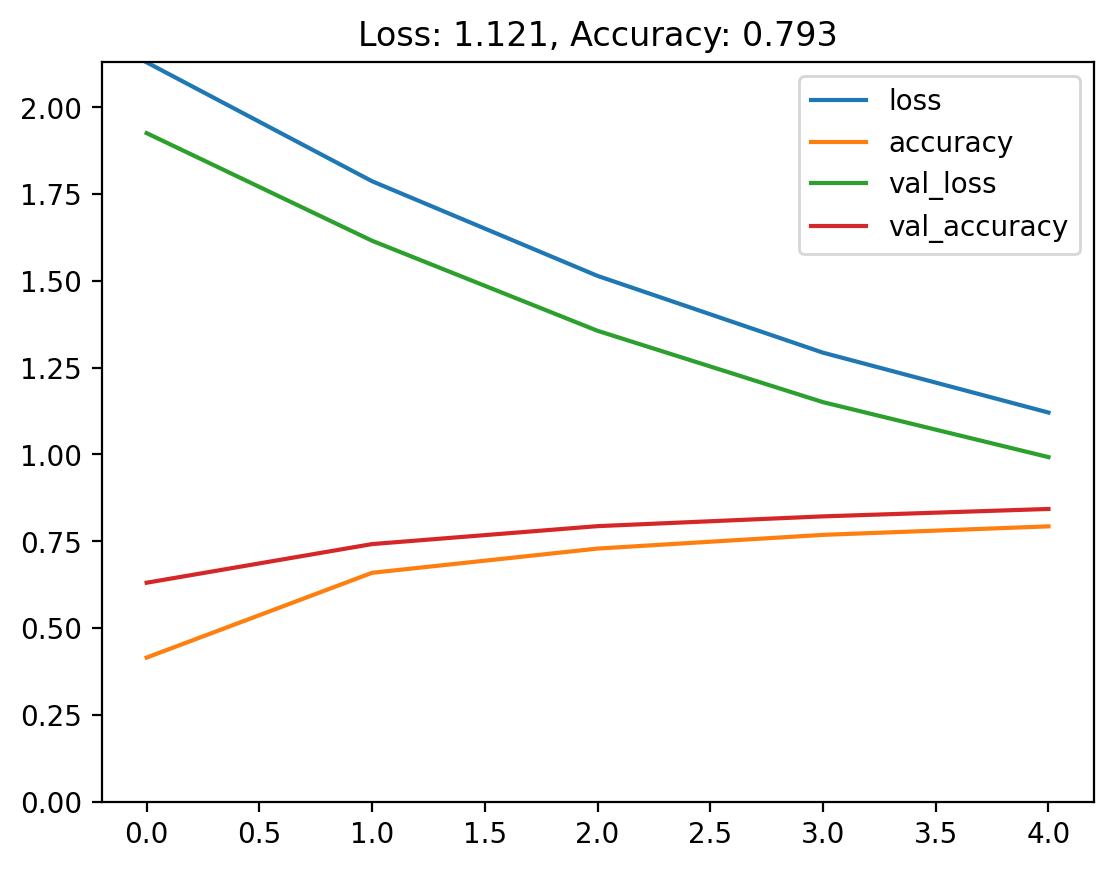

In [14]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Clearly we can see that our model was getting better during training but didn't have enough time to reach its full potential! Let's restart and train it for a bit longer and see if we can get better results.


In [15]:
model = build_basic_model()
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=True, validation_split=.1)


Epoch 1/50
422/422 [==============================] - 2s 3ms/step - loss: 2.0986 - accuracy: 0.4348 - val_loss: 1.8964 - val_accuracy: 0.6632
Epoch 2/50
422/422 [==============================] - 1s 3ms/step - loss: 1.7494 - accuracy: 0.6773 - val_loss: 1.5641 - val_accuracy: 0.7477
Epoch 3/50
422/422 [==============================] - 1s 3ms/step - loss: 1.4621 - accuracy: 0.7310 - val_loss: 1.2989 - val_accuracy: 0.7928
Epoch 4/50
422/422 [==============================] - 2s 5ms/step - loss: 1.2407 - accuracy: 0.7671 - val_loss: 1.1001 - val_accuracy: 0.8245
Epoch 5/50
422/422 [==============================] - 2s 4ms/step - loss: 1.0763 - accuracy: 0.7918 - val_loss: 0.9529 - val_accuracy: 0.8443
Epoch 6/50
422/422 [==============================] - 1s 2ms/step - loss: 0.9537 - accuracy: 0.8107 - val_loss: 0.8420 - val_accuracy: 0.8577
Epoch 7/50
422/422 [==============================] - 1s 3ms/step - loss: 0.8605 - accuracy: 0.8244 - val_loss: 0.7570 - val_accuracy: 0.8717
Epoch 

Let's see what the loss and accuracy curves look like.

<Figure size 800x600 with 0 Axes>

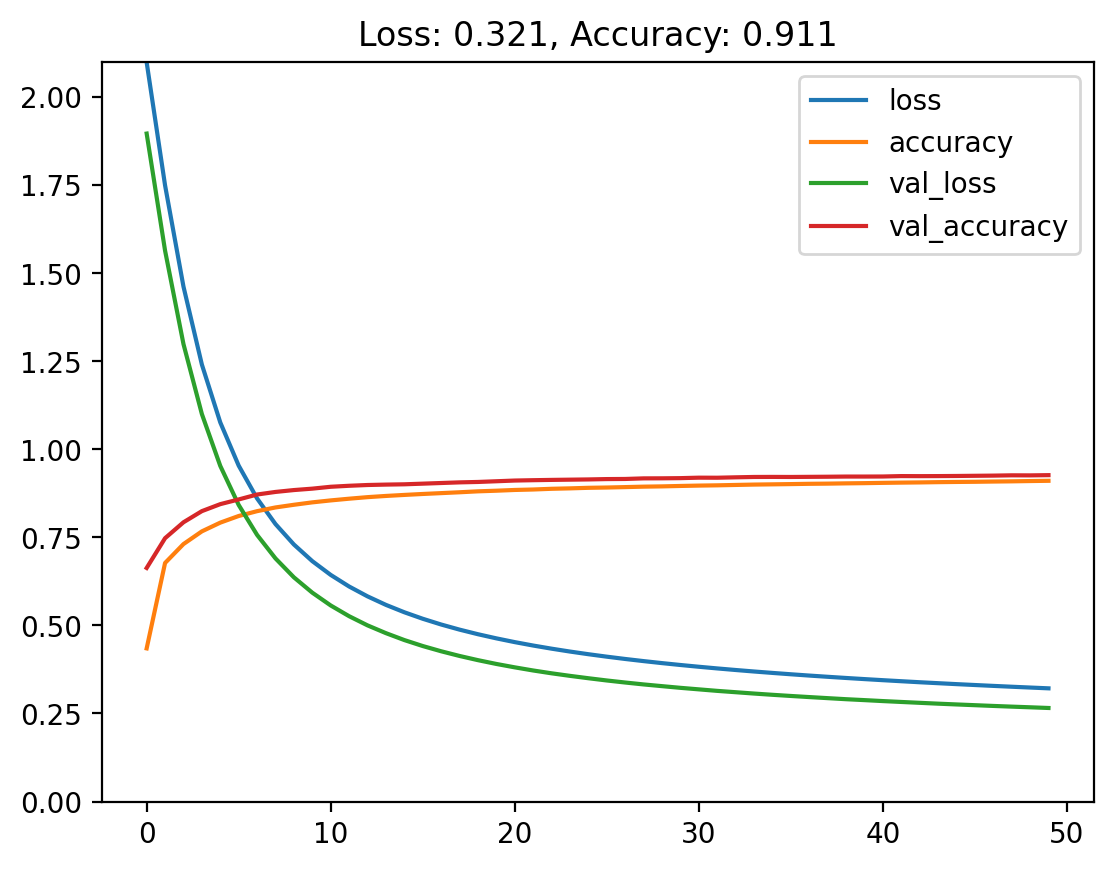

In [16]:
plot_loss_accuracy(history)

That's looking a bit better. Now we can test this trained model on our test set to get the final test result.

In [17]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 0.305
Test accuracy: 0.916


Now lets try out *batch* training, where we train using the entire training set each step.

In [18]:
model = build_basic_model()
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=54000, epochs=50, verbose=True, validation_split=.1)


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 2.4732 - accuracy: 0.1044 - val_loss: 2.4644 - val_accuracy: 0.1108
Epoch 2/50
1/1 [==============================] - 0s 440ms/step - loss: 2.4673 - accuracy: 0.1049 - val_loss: 2.4587 - val_accuracy: 0.1118
Epoch 3/50
1/1 [==============================] - 0s 437ms/step - loss: 2.4615 - accuracy: 0.1055 - val_loss: 2.4531 - val_accuracy: 0.1122
Epoch 4/50
1/1 [==============================] - 0s 443ms/step - loss: 2.4558 - accuracy: 0.1060 - val_loss: 2.4477 - val_accuracy: 0.1125
Epoch 5/50
1/1 [==============================] - 0s 394ms/step - loss: 2.4504 - accuracy: 0.1064 - val_loss: 2.4424 - val_accuracy: 0.1128
Epoch 6/50
1/1 [==============================] - 0s 383ms/step - loss: 2.4450 - accuracy: 0.1069 - val_loss: 2.4373 - val_accuracy: 0.1132
Epoch 7/50
1/1 [==============================] - 0s 403ms/step - loss: 2.4399 - accuracy: 0.1074 - val_loss: 2.4323 - val_accuracy: 0.1142
Epoch 8/50
1/1 [=======

<Figure size 800x600 with 0 Axes>

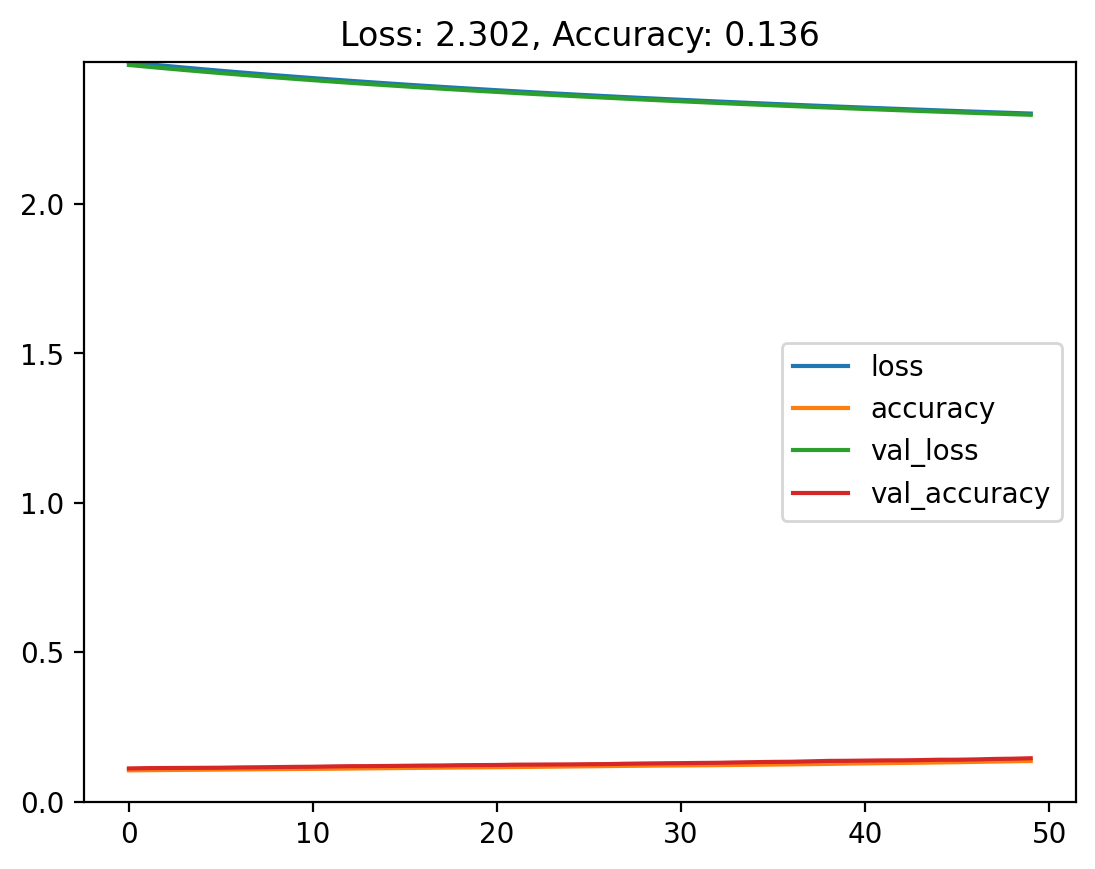

In [19]:
plot_loss_accuracy(history)

Notice how the loss function is reduced much less per each epoch in comparison with  the mini-batch gradient descent.  It's because we update gradient only once per epoch  in batch training but we update it 54000/128=421 times per epoch in the case of mini-batch gradient descent. You will also see that the loss function might look a bit jittery for the mini-batch case. This is because we estimate gradient, and each iteration we might have slightly different estimate \\
Using the whole dataset at each step seems to be converging a bit slow than we would like and we don't have all day to wait around for things to train, so lets try restarting using a increased learning rate.

The default SGD learning rate is 0.01

In [22]:
model = build_basic_model()
model.compile(tf.keras.optimizers.SGD(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=54000, epochs=50, verbose=True, validation_split=.1)


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 2.5469 - accuracy: 0.0945 - val_loss: 2.5268 - val_accuracy: 0.0972
Epoch 2/50
1/1 [==============================] - 1s 583ms/step - loss: 2.5404 - accuracy: 0.0942 - val_loss: 2.5206 - val_accuracy: 0.0972
Epoch 3/50
1/1 [==============================] - 1s 570ms/step - loss: 2.5340 - accuracy: 0.0939 - val_loss: 2.5144 - val_accuracy: 0.0968
Epoch 4/50
1/1 [==============================] - 0s 479ms/step - loss: 2.5278 - accuracy: 0.0937 - val_loss: 2.5085 - val_accuracy: 0.0965
Epoch 5/50
1/1 [==============================] - 0s 427ms/step - loss: 2.5218 - accuracy: 0.0936 - val_loss: 2.5027 - val_accuracy: 0.0960
Epoch 6/50
1/1 [==============================] - 0s 359ms/step - loss: 2.5159 - accuracy: 0.0934 - val_loss: 2.4970 - val_accuracy: 0.0957
Epoch 7/50
1/1 [==============================] - 0s 329ms/step - loss: 2.5102 - accuracy: 0.0934 - val_loss: 2.4914 - val_accuracy: 0.0955
Epoch 8/50
1/1 [=======

<Figure size 800x600 with 0 Axes>

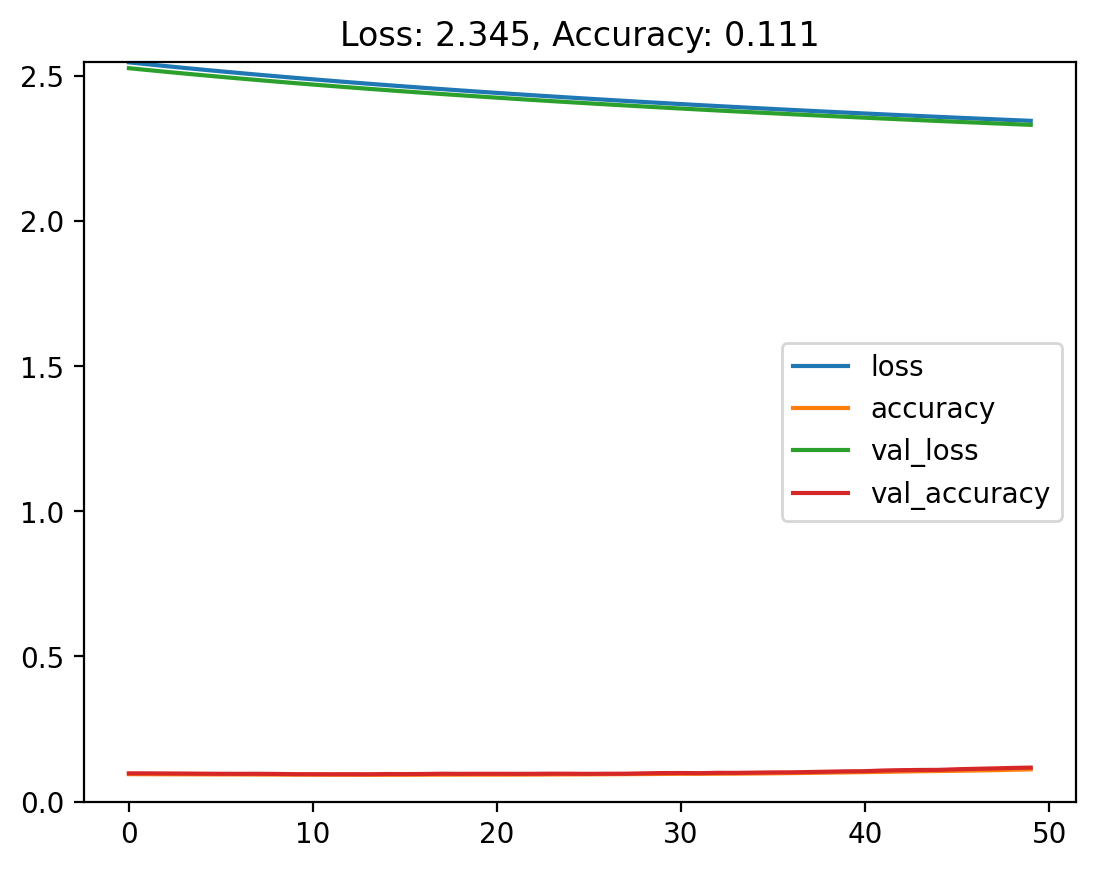

In [23]:
plot_loss_accuracy(history)

In [24]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 2.34
Test accuracy: 0.108


That is an improvement, but what if we move past a simple fixed learning rate like  in the SGD optimizer. Lets have a look at Adam method.
We are going to take the batch size back down to 256 now, feel free to experiment and put your own batch size in.

In [25]:
model = build_basic_model()
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=256, epochs=50, verbose=True, validation_split=.1)

Epoch 1/50
211/211 [==============================] - 2s 4ms/step - loss: 1.2928 - accuracy: 0.7325 - val_loss: 0.7017 - val_accuracy: 0.8907
Epoch 2/50
211/211 [==============================] - 1s 3ms/step - loss: 0.5919 - accuracy: 0.8792 - val_loss: 0.4157 - val_accuracy: 0.9153
Epoch 3/50
211/211 [==============================] - 1s 3ms/step - loss: 0.4169 - accuracy: 0.9019 - val_loss: 0.3173 - val_accuracy: 0.9287
Epoch 4/50
211/211 [==============================] - 1s 3ms/step - loss: 0.3435 - accuracy: 0.9123 - val_loss: 0.2698 - val_accuracy: 0.9338
Epoch 5/50
211/211 [==============================] - 1s 3ms/step - loss: 0.3015 - accuracy: 0.9204 - val_loss: 0.2401 - val_accuracy: 0.9388
Epoch 6/50
211/211 [==============================] - 1s 3ms/step - loss: 0.2732 - accuracy: 0.9256 - val_loss: 0.2224 - val_accuracy: 0.9420
Epoch 7/50
211/211 [==============================] - 1s 3ms/step - loss: 0.2525 - accuracy: 0.9304 - val_loss: 0.2052 - val_accuracy: 0.9455
Epoch 

<Figure size 800x600 with 0 Axes>

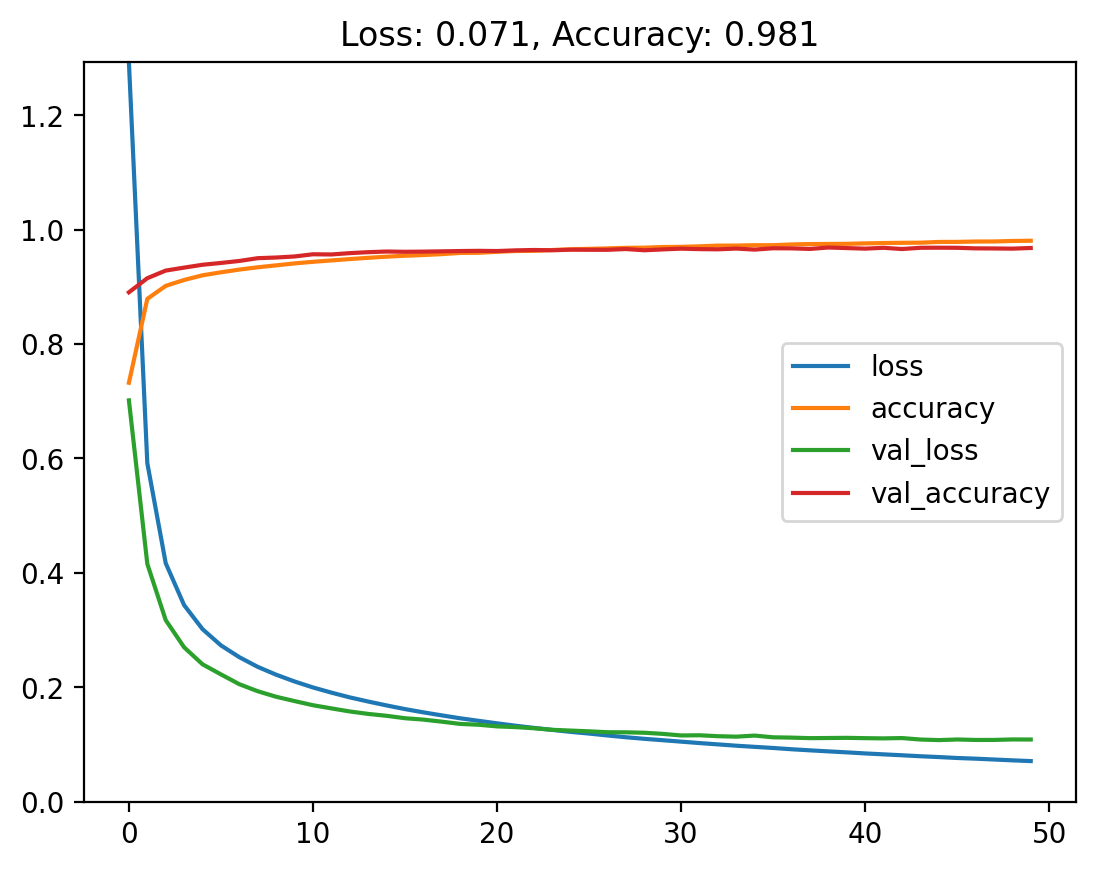

In [26]:
plot_loss_accuracy(history)

In [27]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Test loss: 0.117
Test accuracy: 0.965


That works quite well, Adam allows for more complex learning rate updates than in the SGD optimizer.  It's used frequently in practise.
What if we bump up the starting learning rate on this Adam optimizer?



In [28]:
model = build_basic_model()
model.compile(tf.keras.optimizers.Adam(lr=5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=256, epochs=50, verbose=True, validation_split=.1)

Epoch 1/50
211/211 [==============================] - 1s 4ms/step - loss: 1.3282 - accuracy: 0.7207 - val_loss: 0.7269 - val_accuracy: 0.8900
Epoch 2/50
211/211 [==============================] - 1s 3ms/step - loss: 0.6065 - accuracy: 0.8793 - val_loss: 0.4194 - val_accuracy: 0.9180
Epoch 3/50
211/211 [==============================] - 1s 3ms/step - loss: 0.4213 - accuracy: 0.9009 - val_loss: 0.3164 - val_accuracy: 0.9307
Epoch 4/50
211/211 [==============================] - 1s 3ms/step - loss: 0.3439 - accuracy: 0.9133 - val_loss: 0.2671 - val_accuracy: 0.9368
Epoch 5/50
211/211 [==============================] - 1s 4ms/step - loss: 0.3007 - accuracy: 0.9212 - val_loss: 0.2373 - val_accuracy: 0.9407
Epoch 6/50
211/211 [==============================] - 1s 5ms/step - loss: 0.2716 - accuracy: 0.9277 - val_loss: 0.2165 - val_accuracy: 0.9445
Epoch 7/50
211/211 [==============================] - 1s 5ms/step - loss: 0.2499 - accuracy: 0.9326 - val_loss: 0.2021 - val_accuracy: 0.9473
Epoch 

<Figure size 576x432 with 0 Axes>

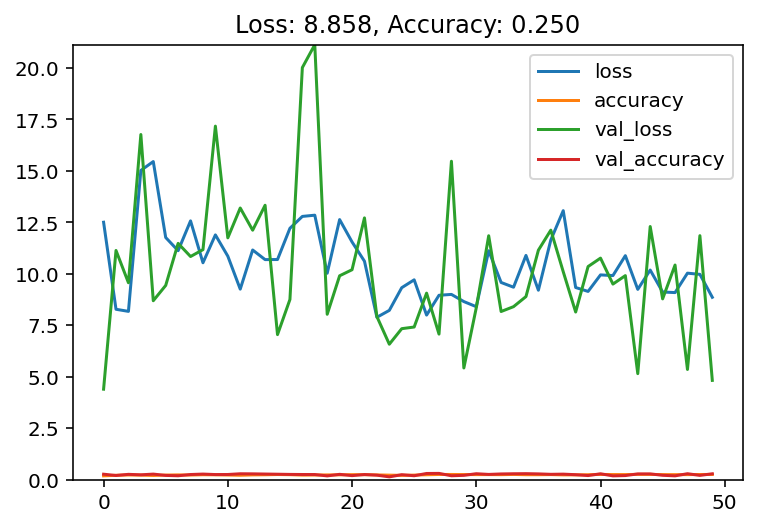

In [ ]:
plot_loss_accuracy(history)

So this is the other end of the scale when it comes to tuning learning rates, this is far too high and the model is actually getting worse during training. We want models to train as quickly as possible so we don't waste our time, but if we get overzealous and set the learning rate too high we might not be able to train at all! Usually we can tell from the loss curve when this is the case though.

Lets try using an optimizer with momentum - it's almost like Adam, it still adapts learning rate in the course of training but with a bit of twist. We will be using the 'Nadam ' optimizer here
Nadam = N(esterov momentum) Adam

In [ ]:
model = build_basic_model()
model.compile('nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=256, epochs=50, verbose=True, validation_split=.1)

Epoch 1/50
211/211 [==============================] - 2s 6ms/step - loss: 1.3808 - accuracy: 0.6953 - val_loss: 0.7482 - val_accuracy: 0.8887
Epoch 2/50
211/211 [==============================] - 1s 5ms/step - loss: 0.6239 - accuracy: 0.8742 - val_loss: 0.4366 - val_accuracy: 0.9117
Epoch 3/50
211/211 [==============================] - 1s 5ms/step - loss: 0.4377 - accuracy: 0.8963 - val_loss: 0.3322 - val_accuracy: 0.9230
Epoch 4/50
211/211 [==============================] - 1s 5ms/step - loss: 0.3600 - accuracy: 0.9078 - val_loss: 0.2805 - val_accuracy: 0.9320
Epoch 5/50
211/211 [==============================] - 1s 5ms/step - loss: 0.3159 - accuracy: 0.9164 - val_loss: 0.2492 - val_accuracy: 0.9383
Epoch 6/50
211/211 [==============================] - 1s 5ms/step - loss: 0.2859 - accuracy: 0.9224 - val_loss: 0.2278 - val_accuracy: 0.9413
Epoch 7/50
211/211 [==============================] - 1s 5ms/step - loss: 0.2634 - accuracy: 0.9277 - val_loss: 0.2112 - val_accuracy: 0.9442
Epoch 

Test loss: 0.123
Test accuracy: 0.964


<Figure size 800x600 with 0 Axes>

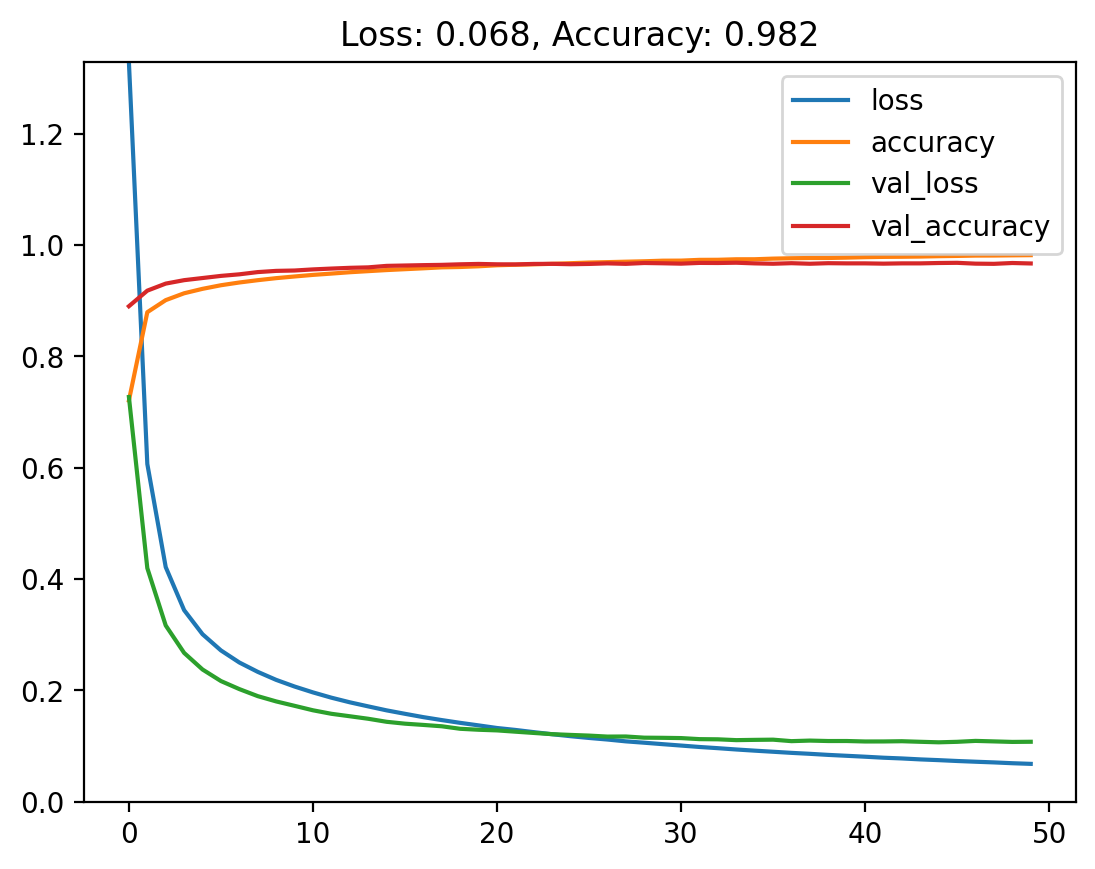

In [29]:
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

All of these models have *in general* converged to ~92 % accuracy. This gives an indication that this is likely to be the maximum capacity of the neural network structure that we have constructed. Considering that this model has just one hidden layer, it is getting pretty solid performance. Lets try  to experiment with a model that is a little bit more complex and see if we can get a little bit higher performance.
One thing to note about creating more complex models is the seriously diminishing returns, in most cases each new layer you add with contribute less to the performance than previous layers. I.e the difference between a 1 and 2 layer model is much bigger than the difference between a 10 and 11 layer model.


Below I have provided two functions, one creates a model with an additional layer, one has a dropout layer in it. Select an optimizer, learning rate and batch size and see if you can beat any of the test accuracies that we managed to get above.

In [ ]:
def build_dropout_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dropout(0.2))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model

def build_deeper_model():
  model = Sequential()
  model.add(Dense(units=64, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=32, activation='sigmoid'))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model



In [ ]:
opt_dict = {'nadam':tf.keras.optimizers.Nadam,
            'adam':tf.keras.optimizers.Adam,
            'sgd':tf.keras.optimizers.SGD,
            'rmsprop':tf.keras.optimizers.RMSprop,
            'adadelta':tf.keras.optimizers.Adadelta,
            'adagrad':tf.keras.optimizers.Adagrad}

If you want to know what the default learning rate values are for the optimizers have a look here: https://keras.io/optimizers/

In [ ]:
model = build_dropout_model()
# or
model = build_deeper_model()
# or make your own model! (recommended)

# set all the following values yourself!
optimizer_name  = '' # any of the following: nadam, adam, sgd, rmsprop, adadelta, adagrad
learning_rate = 0 # some number
batch_size = 1 #some integer
training_epochs = 1 # some integer


# selects optimizer and sets learning rate
optimizer = opt_dict[optimizer_name](lr=learning_rate)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=training_epochs, verbose=True, validation_split=.1)

54000/54000 [==============================] - 118s 2ms/step - loss: 2.5089 - accuracy: 0.0995 - val_loss: 2.5044 - val_accuracy: 0.0960


Test loss: 2.51
Test accuracy: 0.101


<Figure size 576x432 with 0 Axes>

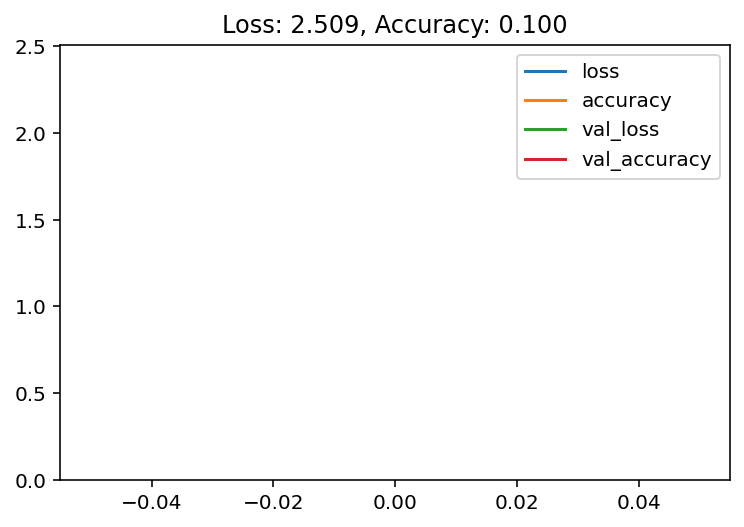

In [ ]:
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Try to use this notebook to build model for Fashion-MNIST dataset